In [1]:
import math
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
def f(x):
    return 5*x**2 + 2*x + 3

In [3]:
f(5)

138

In [4]:
xs = np.arange(-10,10,step=0.5)
ys = f(xs)

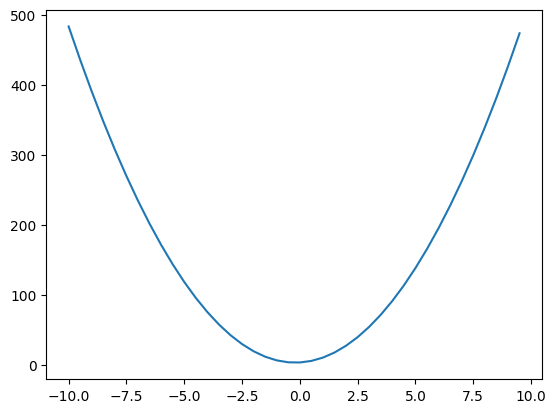

In [5]:
plt.plot(xs,ys)

In [6]:
class Value:

    def __init__(self, data, _children = (), _op='', label=''):
        self.data= data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda : None

    def __repr__(self):
        return f'Value({self.data})'
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self,other), '+')

        def _backward():
            self.grad += out.grad*1
            other.grad += out.grad*1
        out._backward = _backward

        return out
    
    def __mul__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self,other), '*')
        
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward

        return out
    
    def __neg__(self):
        return self*-1
    
    def __sub__(self, other):
        out = self+(-other)
        return out
    
    # def __rsub__(self,other):
    #     return self + (-other)

    def __rmul__(self, other):
        return self * other
    
    def __pow__(self,other):
        assert isinstance(other, (int,float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
    
    def __truediv__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data / other.data, (self, other), '/')

        def _backward():
            self.grad += out.grad * (1 / other.data)
            other.grad += out.grad * (-self.data / (other.data ** 2))

        out._backward = _backward
        return out

    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t,(self, ),label='tanh', _op="tanh")

        def _backward():
            self.grad += out.grad * (1-t**2)
        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x),(self,),'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out
    
    def backward(self):
        self.grad = 1.0

        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        for node in reversed(topo):
            node._backward()

    
a = Value(2, label='a')
b = Value(5, label='b')
c = Value(8, label='c')
e = a*b; e.label='e'
d = e + c ; d.label = 'd'
f = Value(3, label='f')
L = d*f; L.label='L'

In [7]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(
            name=uid,
            label="{%s | data %.4f | %.4f}"% (n.label, n.data, n.grad ),
            shape='record'
        )

        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


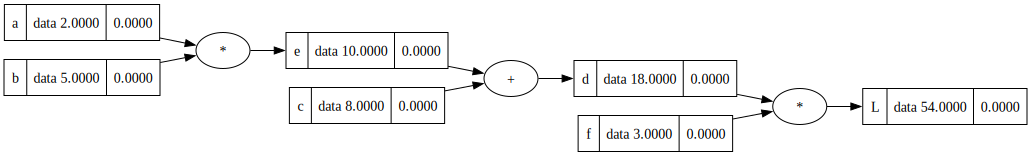

In [8]:
draw_dot(L)

# Chain Rule
L = d*f

dL/dd = f

dL/df = d

d = e + c

dd/dc = 1

dL/dc = dL/dd * dd/dc

dL/dc = f*1

In [9]:
L.grad = 1
f.grad = d.data
d.grad = f.data

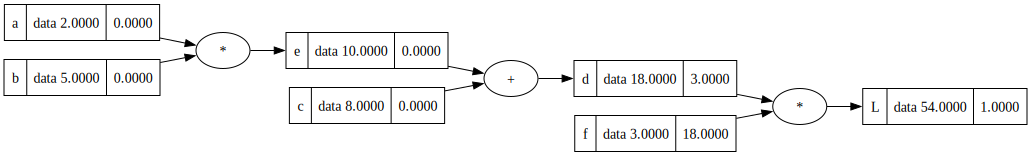

In [10]:
draw_dot(L)

In [11]:
e.grad = d.grad*1
c.grad = d.grad*1

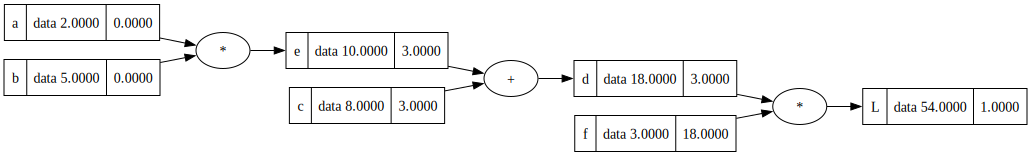

In [12]:
draw_dot(L)

In [13]:
a.grad = b.data*e.grad
b.grad = a.data*e.grad

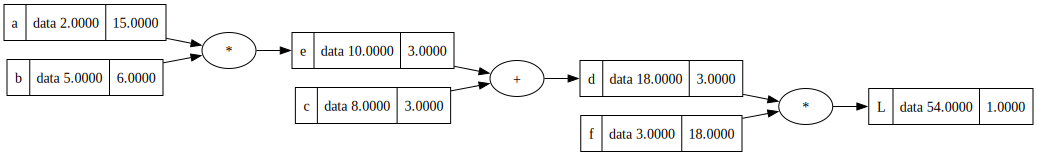

In [14]:
draw_dot(L)

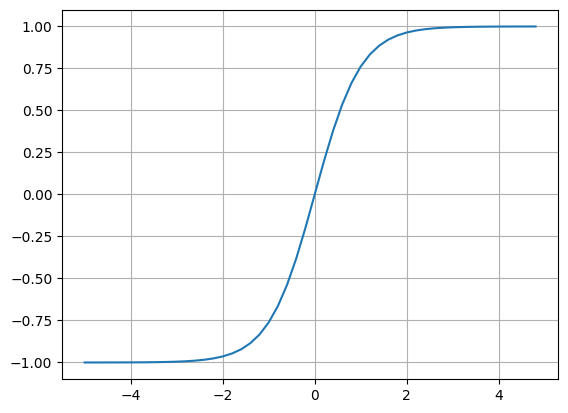

In [15]:
plt.plot(np.arange(-5,5,step=0.2), np.tanh(np.arange(-5,5,step=0.2))); plt.grid()

In [16]:
x1 = Value(2.0,label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')
b = Value(6.7,label='b')
x1w1 = x1*w1; x1w1.label='x1 * w1'
x2w2 = x2*w2; x2w2.label='x2 * w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2"
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label = 'o'

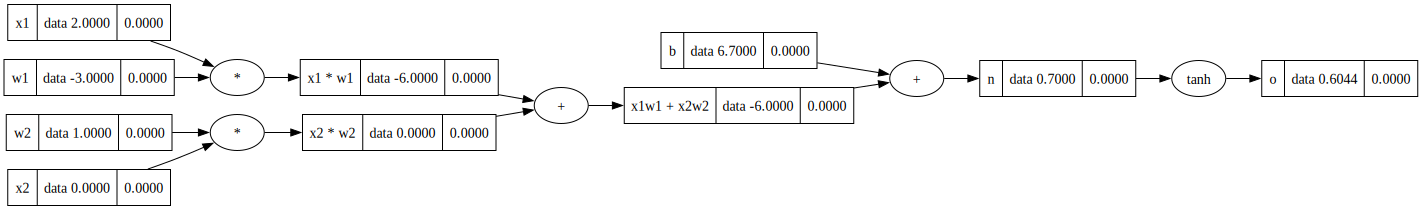

In [17]:
draw_dot(o)

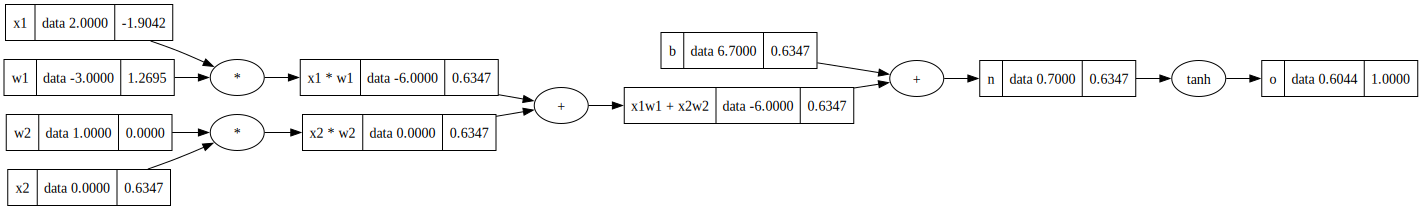

In [18]:
o.backward()
draw_dot(o)

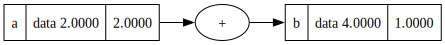

In [19]:
a = Value(2, label='a')
b = a + a;  b.label='b'
b.backward()
draw_dot(b)

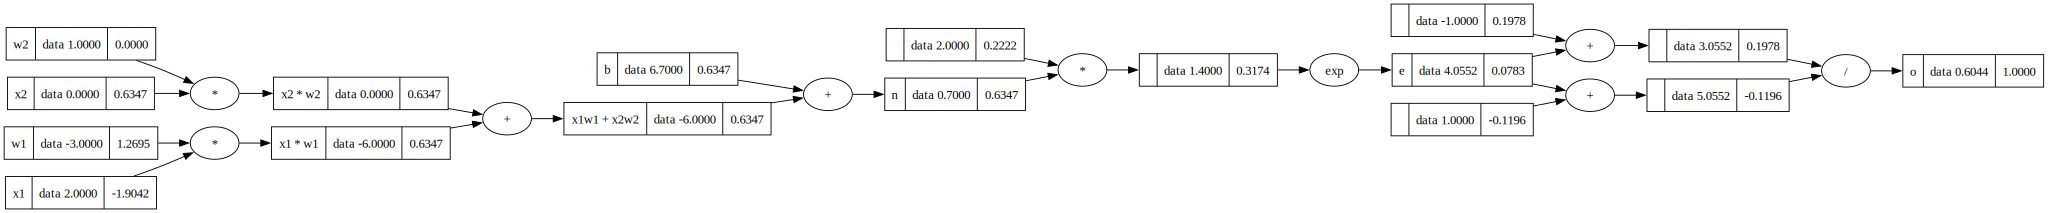

In [20]:
x1 = Value(2.0,label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')
b = Value(6.7,label='b')
x1w1 = x1*w1; x1w1.label='x1 * w1'
x2w2 = x2*w2; x2w2.label='x2 * w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2"
n = x1w1x2w2 + b; n.label='n'
e = (n*2).exp(); e.label = 'e'
o = (e-1)/(e+1); o.label = 'o'
o.backward()

draw_dot(o)

In [21]:
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad =True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.7]).double(); b.requires_grad = True

n = w1*x1 + w2*x2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("----------------------------------")
print('x2: ', x2.grad.item())
print('x1: ', x1.grad.item())
print('w2: ', w2.grad.item())
print('w1: ', w1.grad.item())

0.6043676560501806
----------------------------------
x2:  0.6347397363204106
x1:  -1.9042192089612318
w2:  0.0
w1:  1.2694794726408212


In [22]:
import random
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w,x)) , self.b)
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self,nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

x = [2.0,3.0, 5.0]
o = [4,4,1]
n = MLP(3,o)
out = n(x)
n.parameters()

[Value(0.5135900263794997),
 Value(-0.2809172218519904),
 Value(-0.2078612521127181),
 Value(-0.24637738620224114),
 Value(0.857721085020765),
 Value(-0.9423982323654114),
 Value(0.7124576823311235),
 Value(-0.19902497763570026),
 Value(-0.3703634514592906),
 Value(-0.9167218178323402),
 Value(0.32246388197861786),
 Value(-0.805444445981079),
 Value(0.3243825905057698),
 Value(-0.40030854792122095),
 Value(-0.8823242919747023),
 Value(-0.8361179677505741),
 Value(0.06948462591266358),
 Value(0.08506774119887495),
 Value(-0.04480525754370013),
 Value(-0.2957381185857677),
 Value(-0.6932564810483131),
 Value(-0.985992817589878),
 Value(-0.5503996053033631),
 Value(0.7157490958938157),
 Value(0.6363008871504687),
 Value(0.38039133103060596),
 Value(0.849126649809679),
 Value(0.8521349731544534),
 Value(0.7246344678124013),
 Value(0.7967332977566941),
 Value(0.1741533112466349),
 Value(-0.20388828314214247),
 Value(-0.20344612140573104),
 Value(-0.16634919051630526),
 Value(0.9549540436437

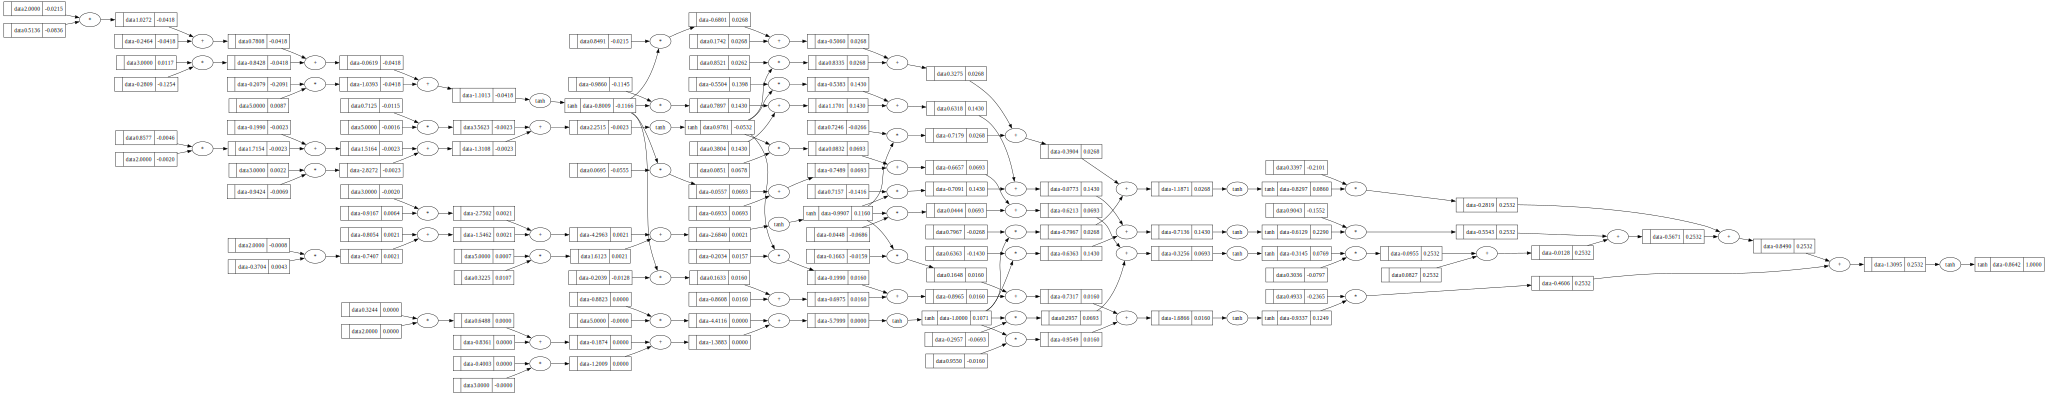

In [23]:
out.backward()
draw_dot(out)

In [29]:
xs = [
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0]
]

ys = [1.0,-1.0,-1.0,1.0]

In [30]:
for k in range(100):

    ypred = [n(x) for x in xs]
    loss = sum(((Value(ygt) - yout) ** 2 for ygt, yout in zip(ys, ypred)), Value(0.0))

    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)

0 5.806310999611754
1 0.9456797491242152
2 0.4406648336166415
3 0.2978421611091089
4 0.22147224905604607
5 0.17484645856190528
6 0.1437371750626502
7 0.12163575453322464
8 0.10518877147956175
9 0.0925071201098503
10 0.08245089343440111
11 0.07429388247163375
12 0.06755267867848119
13 0.06189364171157889
14 0.05707941049797846
15 0.05293671214549665
16 0.04933622316306703
17 0.04617954451303355
18 0.043390530913031196
19 0.04090937096848467
20 0.03868845416039904
21 0.03668942745733933
22 0.034881061524518045
23 0.03323767887143601
24 0.03173797903990523
25 0.03036414888624845
26 0.02910118060702863
27 0.02793634319444146
28 0.02685876861655078
29 0.02585912476393943
30 0.02492935471248382
31 0.024062467169380743
32 0.023252366783158326
33 0.022493715765681304
34 0.02178182030419544
35 0.02111253674590719
36 0.020482193663221515
37 0.01988752675751638
38 0.01932562420624966
39 0.018793880554605943
40 0.018289957636670774
41 0.017811751309925055
42 0.017357363021059898
43 0.0169250754058